In [1]:
import grid2op
from grid2op.PlotGrid import PlotMatplot
from grid2op.Agent import BaseAgent
from grid2op.Runner import Runner
from grid2op.Agent import DoNothingAgent
from grid2op.Parameters import Parameters
import os
import shutil
import numpy as np

# Build expert agents

In [5]:
p = Parameters()
p.NO_OVERFLOW_DISCONNECTION = False
env_name  = "l2rpn_wcci_2022_dev"
env = grid2op.make(env_name, param=p)
_ = env.seed(0)

In [19]:
env.gen_type, env.gen_renewable

(array(['nuclear', 'thermal', 'wind', 'solar', 'solar', 'hydro'],
       dtype='<U10'),
 array([False, False,  True,  True,  True, False]))

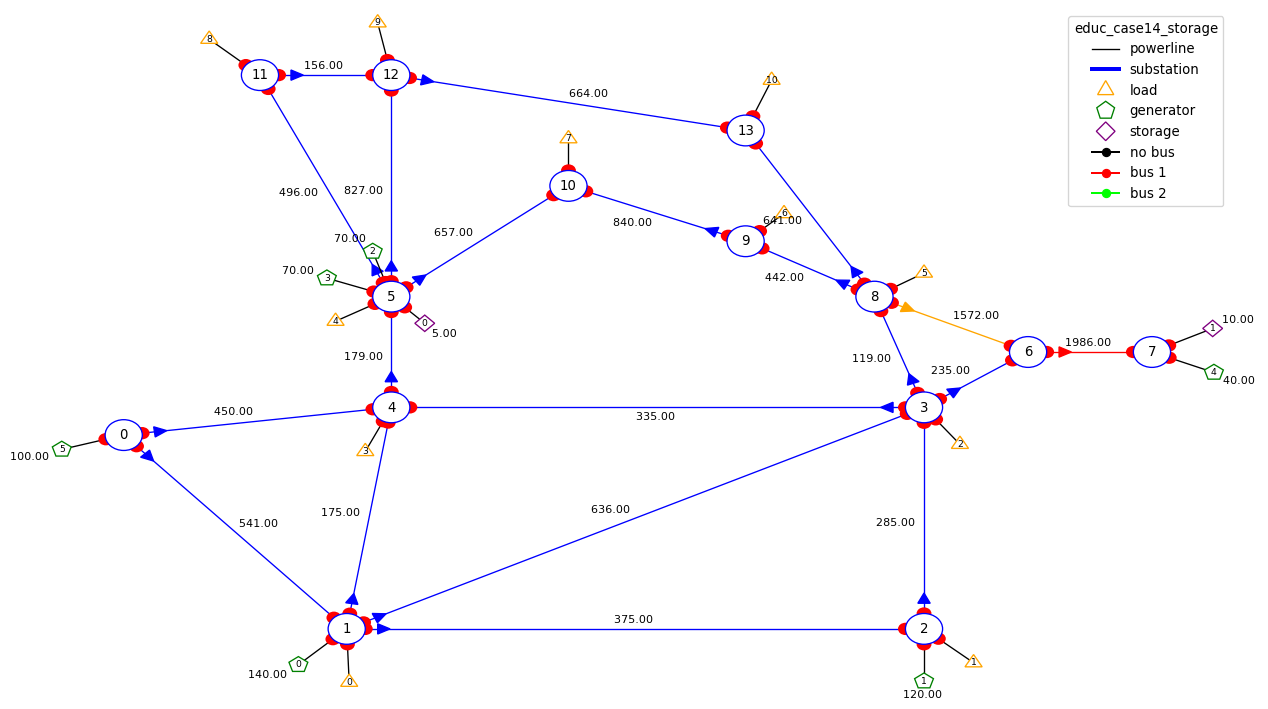

In [20]:
plot_helper = PlotMatplot(env.observation_space)
_ = plot_helper.plot_info(line_values=env._thermal_limit_a, coloring="line", gen_values=env.gen_pmax, storage_values=env.storage_max_p_prod)

In [5]:
def test_agent(agent_class, agent_name, env, nb_episode=1, path_agents="output_agents"):
  env.seed(0)
  path_this_agent = os.path.join(path_agents, agent_name)
  shutil.rmtree(os.path.abspath(path_this_agent),ignore_errors=True)
  runner = Runner(**env.get_params_for_runner(), agentClass=agent_class)

  res = runner.run(nb_episode=nb_episode, path_save=path_this_agent)

  print(f"The results for the {agent_name} agent are:")
  for _, chron_name, cum_reward, nb_time_step, max_ts in res:
    msg_tmp = "\tFor chronics with id {}\n".format(chron_name)
    msg_tmp += "\t\t - cumulative reward: {:.6f}\n".format(cum_reward)
    msg_tmp += "\t\t - number of time steps completed: {:.0f} / {:.0f}".format(nb_time_step, max_ts)
    print(msg_tmp)

In [6]:
class ExpertAgent(BaseAgent):
  def __init__(self, action_space):
    # python required method to code
    BaseAgent.__init__(self, action_space)
    self.do_nothing = self.action_space({})
    # self.print_next = True
        
  def act(self, obs, reward, done=False):
    max_rho = np.max(obs.rho)
    action = self.action_space({})

    if max_rho < 0.90:
      # Charger les batteries
      mask = (obs.storage_charge / obs.storage_Emax) < 0.95
      batteries_to_charge = np.where(mask)[0]
      action.storage_p = [(battery, obs.storage_max_p_absorb[battery]/5) for battery in batteries_to_charge]

      # Reset redispatching
      if np.any(obs.target_dispatch):
        gen_dispatched_up = np.where(obs.target_dispatch>0)[0]
        gen_dispatched_down = np.where(obs.target_dispatch<0)[0]
        to_redispatch = [(gen, max(-obs.target_dispatch[gen], -obs.gen_max_ramp_down[gen])) for gen in gen_dispatched_up]
        to_redispatch += [(gen, min(-obs.target_dispatch[gen], obs.gen_max_ramp_up[gen])) for gen in gen_dispatched_down]
        action.redispatch = to_redispatch

    else :
      # Décharger les batteries
      batteries_to_discharge = [0] if max_rho < 0.95 else [0, 1]
      action.storage_p = [(battery, -obs.storage_max_p_prod[battery]*0.4) for battery in batteries_to_discharge]

      # Redispatching
      if max_rho > 0.95 and not np.any(obs.target_dispatch):
        action.redispatch = [(gen, -obs.gen_max_ramp_down[gen]) for gen in [0, 5]] + [(gen, obs.gen_max_ramp_up[gen]) for gen in [1]]

    # Simulate our action
    _, _, done, _ = obs.simulate(action)

    if done:
      return self.do_nothing
    else:
      return action

In [7]:
class ExpertAgent2(BaseAgent):
  def __init__(self, action_space):
    # python required method to code
    BaseAgent.__init__(self, action_space)
    self.do_nothing = self.action_space({})
    # self.print_next = True
        
  def act(self, obs, reward, done=False):
    max_rho = np.max(obs.rho)
    action = self.action_space({})
    storage_p = []

    if max_rho < 0.90:
      # Maintenir batterie 1 à 1 et batterie 0 à 0.50
      c0, c1 = (i for i in obs.storage_charge / obs.storage_Emax)
      if c1 <= 0.95:
        storage_p.append((1, obs.storage_max_p_absorb[1]/5))
      if c0 <= 0.45:
        storage_p.append((0, obs.storage_max_p_absorb[0]/5))
      elif c0 >= 0.55:
        storage_p.append((0, -obs.storage_max_p_prod[0]/5))

    
      # Reset redispatching
      if np.any(obs.target_dispatch):
        gen_dispatched_up = np.where(obs.target_dispatch>0)[0]
        gen_dispatched_down = np.where(obs.target_dispatch<0)[0]
        to_redispatch = [(gen, max(-obs.target_dispatch[gen], -obs.gen_max_ramp_down[gen])) for gen in gen_dispatched_up]
        to_redispatch += [(gen, min(-obs.target_dispatch[gen], obs.gen_max_ramp_up[gen])) for gen in gen_dispatched_down]
        action.redispatch = to_redispatch

    else:
      # Gestion des batteries : batterie 1 produit et batterie 0 s'adapte
      if max_rho>0.95:
        storage_p.append((1, -obs.storage_max_p_prod[1]*0.4))
      if obs.rho[17]==max_rho:
        storage_p.append((0, -obs.storage_max_p_prod[0]*0.4))
      else:
        storage_p.append((0, obs.storage_max_p_absorb[0]))

      # Redispatching
      if max_rho >= 0.95 and not np.any(obs.target_dispatch):
        action.redispatch = [(gen, -obs.gen_max_ramp_down[gen]) for gen in [0, 5]] + [(gen, obs.gen_max_ramp_up[gen]) for gen in [1]]

    if len(storage_p) > 0:
      action.storage_p = storage_p

    # Simulate our action
    _, _, done, _ = obs.simulate(action)

    if done:
      return self.do_nothing
    else:
      return action

In [8]:
test_agent(ExpertAgent2, "Expert2", env, nb_episode=7)

The results for the Expert2 agent are:
	For chronics with id 2019-01-12
		 - cumulative reward: 4684.643066
		 - number of time steps completed: 288 / 288
	For chronics with id 2019-01-13
		 - cumulative reward: 4681.903809
		 - number of time steps completed: 288 / 288
	For chronics with id 2019-01-14
		 - cumulative reward: 3415.627686
		 - number of time steps completed: 225 / 288
	For chronics with id 2019-01-15
		 - cumulative reward: 4319.284668
		 - number of time steps completed: 288 / 288
	For chronics with id 2019-01-16
		 - cumulative reward: 3619.999023
		 - number of time steps completed: 235 / 288
	For chronics with id 2019-01-17
		 - cumulative reward: 4320.293457
		 - number of time steps completed: 288 / 288
	For chronics with id 2019-01-18
		 - cumulative reward: 3503.053223
		 - number of time steps completed: 238 / 288


In [9]:
test_agent(DoNothingAgent, "DN", env, nb_episode=7)

The results for the DN agent are:
	For chronics with id 2019-01-12
		 - cumulative reward: 4688.167480
		 - number of time steps completed: 288 / 288
	For chronics with id 2019-01-13
		 - cumulative reward: 4685.237305
		 - number of time steps completed: 288 / 288
	For chronics with id 2019-01-14
		 - cumulative reward: 3330.406250
		 - number of time steps completed: 219 / 288
	For chronics with id 2019-01-15
		 - cumulative reward: 1374.079468
		 - number of time steps completed: 89 / 288
	For chronics with id 2019-01-16
		 - cumulative reward: 3609.946533
		 - number of time steps completed: 235 / 288
	For chronics with id 2019-01-17
		 - cumulative reward: 3533.431396
		 - number of time steps completed: 233 / 288
	For chronics with id 2019-01-18
		 - cumulative reward: 1267.627197
		 - number of time steps completed: 85 / 288


# Study the agents

In [10]:
from grid2op.Episode import EpisodeData
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [11]:
path_agents = "output_agents"
agent_name = "Expert2"
path_agent = os.path.join(path_agents, agent_name)

In [12]:
episode_studied = EpisodeData.list_episode(path_agent)
episode_studied

[('/Users/gaetanserre/Documents/Projects/L2RPN-WCCI-Baselines/output_agents/Expert2',
  '2019-01-12'),
 ('/Users/gaetanserre/Documents/Projects/L2RPN-WCCI-Baselines/output_agents/Expert2',
  '2019-01-13'),
 ('/Users/gaetanserre/Documents/Projects/L2RPN-WCCI-Baselines/output_agents/Expert2',
  '2019-01-14'),
 ('/Users/gaetanserre/Documents/Projects/L2RPN-WCCI-Baselines/output_agents/Expert2',
  '2019-01-15'),
 ('/Users/gaetanserre/Documents/Projects/L2RPN-WCCI-Baselines/output_agents/Expert2',
  '2019-01-16'),
 ('/Users/gaetanserre/Documents/Projects/L2RPN-WCCI-Baselines/output_agents/Expert2',
  '2019-01-17'),
 ('/Users/gaetanserre/Documents/Projects/L2RPN-WCCI-Baselines/output_agents/Expert2',
  '2019-01-18')]

In [13]:
this_episode = EpisodeData.from_disk(*episode_studied[2])
this_episode

In [14]:
episode_data = this_episode
this_episode.observations[-1].hour_of_day
datetime(year=episode_data.observations[-1].year,
         month=episode_data.observations[-1].month,
         day=episode_data.observations[-1].day,
         hour=episode_data.observations[-1].hour_of_day,
         minute=episode_data.observations[-1].minute_of_hour)

datetime.datetime(2019, 1, 14, 18, 45)

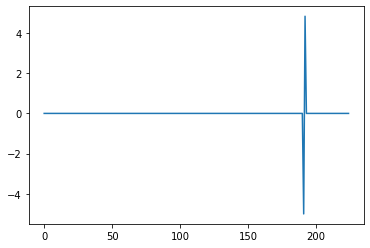

In [15]:
l = []
for act in this_episode.actions:
    dict_ = act.effect_on(gen_id=0)
    # print(dict_)
    l.append(dict_['redispatch'])
plt.plot(l)
plt.show()

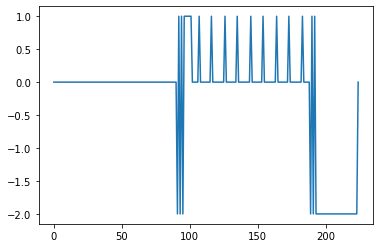

In [16]:
l = []
for act in this_episode.actions:
    dict_ = act.effect_on(storage_id=0)
    # print(dict_)
    l.append(dict_['power'])
plt.plot(l)
plt.show()

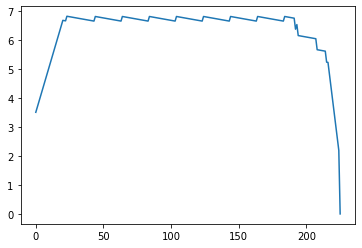

In [17]:
l = []
for obs in this_episode.observations:
    dict_ = obs.state_of(storage_id=1)
    # print(dict_)
    l.append(dict_['storage_charge'])
plt.plot(l)
plt.show()

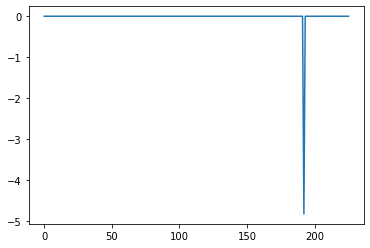

In [18]:
l = []
for obs in this_episode.observations:
    dict_ = obs.state_of(gen_id=0)
    # print(dict_)
    l.append(dict_['target_dispatch'])
plt.plot(l)
plt.show()